# The fast spectral method

By choosing the test function $\phi(v) = e^{-i\frac{\pi}{L} k\cdot v}$ in the weak form, we can obtain the Fourier expansion of $Q$:

$$\hat{Q}_k= \sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1} G(l,m) \hat{f}_l \hat{f}_m\,,$$

where the weight $G(l,m)$ is given by

$$
G(l,m)=\int_{\mathbb{R}^d}e^{-i\frac{\pi}{L}m \cdot g}\bigg[\int_{S^{d-1}}B_{\sigma}(\lvert g\rvert,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}{\sigma}\bigg]\,\mathrm{d}{g} \,,
$$

where $g$ needs to be truncated properly as was done for the elastic case. 

The idea of the fast algorithm is to separate the weight $G$ as $G(l,m)\approx\sum_{t=1}^T\alpha_t(l+m)\beta_t(m)$ using quadrature rules.

In [26]:
%matplotlib inline
import numpy as np
from math import pi
from scipy import special
import matplotlib.pyplot as plt
import pyfftw

from fast_spec_col_2d import FastSpectralCollison2D
from fast_spec_col_3d import FastSpectralCollison3D
# parellel module
# from pathos.multiprocessing import ProcessingPool

In [3]:
# Runge-Kutta schemes

def Euler(f, L, eps, dt):
    return f + dt*L(f, eps)

def RK2(f, L, eps, dt):
    k1 = L(f, eps)
    return f + dt*L(f + 0.5*dt*k1, eps)

def RK3(f, L, eps, dt):
    k1 = L(f, eps)
    k2 = L(f + 0.5*dt*k1, eps)
    k3 = L(f - dt*k1 + 2*dt*k2, eps)
    return f + 1/6*dt*(k1 + 4*k2 + k3)

def RK4(f, L, eps, dt):
    k1 = L(f, eps)
    k2 = L(f + 0.5*dt*k1, eps)
    k3 = L(f + 0.5*dt*k2, eps)
    k4 = L(f + dt*k3, eps)
    return f + dt*(k1 + 2*k2 + 2*k3 + k4)/6

In [4]:
def plot_2d(f, cs):
    N = f.shape[0]
    dv = 2*L/N
    v = np.mgrid[-L+dv/2:L+dv/2:dv,-L+dv/2:L+dv/2:dv]
    v_norm = v[0]**2 + v[1]**2

    fig, ax = plt.subplots()
    cs = ax.contour(v[0], v[1], f)
    if cs == 1:
        ax.clabel(cs, inline=0.5)
        
    ax.grid(linestyle=':')

    plt.show()

## 2D case

In 2D, and VHS case $B_{\sigma}(|g|,\sigma\cdot \hat{g})=C_{\gamma}|g|^{\gamma}$:

$$
\int_{S^1}B_{\sigma}(|g|,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}{\sigma}=2\pi C_{\gamma}|g|^{\gamma}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot g}\text{J}_0\left(\frac{\pi}{L}\frac{1+e}{4}|l+m||g|\right)-1\right],
$$

then let $\rho=|g|$, $\sigma=\hat{g}$,

$$
G(l,m)=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}2\pi C_{\gamma}\rho^{\gamma+1}e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho (l+m)\cdot \sigma}\text{J}_0\left(\frac{\pi}{L}\frac{1+e}{4}|l+m|\rho\right)-1\right],
$$

therefore,

$$ 
\hat{Q}_k=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}2\pi C_{\gamma}\rho^{\gamma+1}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho k\cdot \sigma}\text{J}_0\left(\frac{\pi}{L}\frac{1+e}{4}\rho |k|\right)-1\right]\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right],
$$

or the loss term can be computed separately as

$$ 
\hat{Q}_k^-=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}2\pi C_{\gamma}\rho^{\gamma+1}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right]=\sum_{\rho}w_{\rho}4\pi^2 C_{\gamma}\rho^{\gamma+1}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[\text{J}_0\left(\frac{\pi}{L}\rho |m|\right)\hat{f}_m\right].
$$

## 2D accuracy test

Maxwell molecule:

$$
B_\sigma(|g|, \sigma\cdot \hat{g}) = C_0 b_0(\sigma\cdot\hat{g}).
$$

Initial value

$$
f(t,v) = \frac{1}{2\pi K^2}\exp\left(-\frac{v^2}{2K}\right)\left(2K - 1 + \frac{1-K}{2K}v^2\right),
$$

where $K = 1 - \exp(-t/8)/2$ with $t = 0.5$. 

In [28]:
# computation domain
S = 4.5
R = 2*S
L = 0.5*(3+np.sqrt(2))*S

N = 256
N_R = 30
e = 1

dv = 2*L/N
v = np.ogrid[-L+dv/2:L+dv/2:dv,-L+dv/2:L+dv/2:dv]

t = 0.5
K = 1 - np.exp(-t/8)/2
dK = np.exp(-t/8)/16

v_norm = v[0]**2 + v[1]**2

# initial f_0
f_0 = 1/(2*pi*K**2)*np.exp(-v_norm/(2*K))*(2*K-1+(1-K)*v_norm/(2*K))
# initial moments
rho_0 = np.sum(f_0)*dv**2
u_0_norm = (np.sum(f_0*v[0])*dv**2)**2 + (np.sum(f_0*v[1])*dv**2)**2
E_0 = 0.5*np.sum(f_0*v_norm)*dv**2
# exact solution
df = (-2/K+v_norm/(2*K**2))*f_0 + 1/(2*pi*K**2)*np.exp(-v_norm/(2*K))*(2-v_norm/(2*K**2))
df = df*dK
extQ = df

In [6]:
E_0

0.9999999999999998

In [7]:
Q = FastSpectralCollison2D(e, 0, L, N, R, N_R, M=30)

In [8]:
%time Q1 = Q.col_full(f_0)/2/pi
%time Q2 = Q.col_sep(f_0)/2/pi

CPU times: user 7.22 s, sys: 1.2 s, total: 8.42 s
Wall time: 2.85 s
CPU times: user 7.53 s, sys: 640 ms, total: 8.17 s
Wall time: 2.61 s


In [ ]:
Q2[20, 20]

In [ ]:
extQ[23, 23]

In [10]:
np.max(np.abs(Q1 - extQ))

1.3147895139021528e-10

We also have $\rho_0 = 1$, $u_0 = 0$, $E = T$. Temperature $T$ safisfies:

$$
T=\left(T_0-\frac{8\varepsilon}{1-e^2}\right)\exp{\left(-\frac{1-e^2}{4}t\right)}+\frac{8\varepsilon}{1-e^2}.
$$

### Numerical Scheme

In [4]:
# computation domain
S = 3.5
R = 2*S
L = 0.5*(3+np.sqrt(2))*S

In [7]:
class TestModule:
    
    def __init__(self, N, initial, e, gamma=0, eps=0, L=6.62, R=6, N_R=30, M=30):
        self.N, self.L, self.eps, self.e = N, L, eps, e
        self.dv, self.v_norm = [], []
        self.f0, self.Q = [], []
        for n in N:
            dv = 2*L/n
            v = np.arange(-L+dv/2, L+dv/2, dv)
            v_norm = (v**2)[:,None] + v**2
            self.dv.append(dv)
            self.v_norm.append(v_norm)
            self.f0.append(initial(n, L))
            self.Q.append(FastSpectralCollison2D(e, gamma, L, n, R, N_R, M))
            
    def ext_T(self, N_index, tfinal):
        v_norm, dv = self.v_norm[N_index], self.dv[N_index]
        T_0 = 0.5*np.sum(self.f0[N_index]*v_norm)*dv**2
#         T_0 = 1.425
        return (T_0 - 8*self.eps/(1-self.e**2))*np.exp(-(1-self.e**2)*tfinal/4) + 8*self.eps/(1-self.e**2)
    
    def solve(self, dt, N_index, Q, Q_col, RK, tfinal):
        v_norm, dv = self.v_norm[N_index], self.dv[N_index]
        f_hat = Q.fft2(self.f0[N_index])
        for t in np.arange(0, tfinal, dt):
            f_hat = RK(f_hat, Q_col, self.eps, dt)    
        f = np.real(Q.ifft2(f_hat))
        return f, 0.5*np.sum(f*v_norm)*dv**2
            
    def dt_test(self, Dt, method='separate', RK=RK3, N_index=3, tfinal=2):
        Q = self.Q[N_index]
        if method == 'full':
            Q_col = Q.col_heat_hat_full
        else:
            Q_col = Q.col_heat_hat_sep
        
        num_T, num_f = [], []
        for dt in Dt:
            f, T = self.solve(dt, N_index, Q, Q_col, RK, tfinal)
            num_T.append(T)
            num_f.append(f)
        return np.abs(np.asarray(num_T) - self.ext_T(N_index, tfinal)), num_f, num_T
    
    def N_test(self, dt, method='separate', RK=RK3, tfinal=2):   
        num_T, num_f, ext_T = [], [], []
        for N_index in [0,1,2,3,4]:
            Q = self.Q[N_index]
            if method == 'full':
                Q_col = Q.col_heat_hat_full
            else:
                Q_col = Q.col_heat_hat_sep
                
            f, T = self.solve(dt, N_index, Q, Q_col, RK, tfinal)
            num_T.append(T)
            num_f.append(f)
            ext_T.append(self.ext_T(N_index, tfinal))
            
        return np.abs(np.asarray(num_T) - np.asarray(ext_T)), num_f, num_T
            

In [8]:
def initial1(N, L):
    dv = 2*L/N
    v = np.arange(-L+dv/2, L+dv/2, dv)
    v_norm = (v**2)[:,None] + v**2
    t = 0.5
    K = 1 - 0.5*np.exp(-t/8)
    return 1/(2*pi*K**2)*np.exp(-0.5*v_norm/K)*(2*K-1+0.5*v_norm*(1-K)/K)

In [10]:
def initial2(N, L):
    dv = 2*L/N
    v = np.arange(-L+dv/2, L+dv/2, dv)
    return 0.8/pi*(np.exp(-(v-2)[:,None]**2/0.25-(v-2)**2/0.25) + np.exp(-(v+0.5)[:,None]**2-(v+0.5)**2))

In [ ]:
f0 = initial1(64, L)
plot_2d(f0, 0)

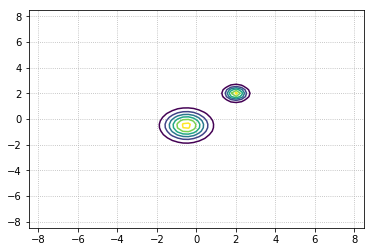

In [11]:
f0 = initial2(64, L)
plot_2d(f0, 0)

In [12]:
N = f0.shape[0]
dv = 2*L/N
v = np.mgrid[-L+dv/2:L+dv/2:dv,-L+dv/2:L+dv/2:dv]
v_norm = v[0]**2 + v[1]**2

np.sum(f0*v[1])*dv**2

3.0204664932396997e-15

In [13]:
np.sum(f0)*dv**2

1.000000000000001

In [14]:
0.5*np.sum(f0*v_norm)*dv**2

1.4250000000000027

In [ ]:
def plot_err(x, err, rate, name):
    fig, ax = plt.subplots()
    ax.loglog(x, err, 'o-', label='numerical error of $T$')
    ax.loglog(x, np.asarray(x)**rate, label='reference: 3-order')
    ax.set_xlabel('$\Delta t$')
    ax.set_ylabel('error of $T$')
    ax.set_title('Convergence of RK3 in $\Delta t$')
    ax.legend(fontsize='large')
    ax.grid(which='both',linestyle=':')
    plt.savefig(name)
    plt.show()

### Time convergence 1

In [15]:
%%time
# computation domain
S = 3.9
R = 2*S
L = 0.5*(3+np.sqrt(2))*S

N = np.array([8, 16, 32, 64, 128])
test = TestModule(N, initial1, 0.2, eps=1e-6, L=L, R=R)

CPU times: user 4.58 s, sys: 426 ms, total: 5.01 s
Wall time: 5.01 s


In [16]:
L, R

(8.607716446627535, 7.8)

In [ ]:
plot_2d(test.f0[3], 0)

In [ ]:
%%time
# Dt = [0.1, 0.05, 0.02, 0.01, 0.005]
Dt = [0.5, 0.4, 0.2, 0.1, 0.05, 0.04, 0.02, 0.01]
# Dt = [0.1]
err, num_f, num_T = test.dt_test(Dt, method='full', RK=RK3, N_index=3)
np.savez('test', dt=Dt, err=err, num_T=num_T, num_f=num_f)

In [ ]:
err

In [ ]:
np.savez('dt_2d_bgk_e_full=0.2', dt=Dt, err=err, num_T=num_T, num_f=num_f)

In [ ]:
plot_2d(num_f[5], 0)

In [ ]:
plot_err(Dt, err, 3, 'dt_2d_bgk_e_full=0.2.pdf')

### Time convergence 2

In [17]:
%%time
# computation domain
S = 4
R = 2*S
L = 0.5*(3+np.sqrt(2))*S

N = np.array([8, 16, 32, 64, 128])
test = TestModule(N, initial2, 0.2, eps=1e-6, L=L, R=R)

CPU times: user 4.53 s, sys: 503 ms, total: 5.03 s
Wall time: 5.03 s


In [18]:
L

8.82842712474619

In [ ]:
plot_2d(test.f0[3], 0)

In [ ]:
%%time
Dt = [0.5, 0.4, 0.2, 0.1, 0.05, 0.04, 0.02, 0.01]
# Dt = [1, 0.8, 0.7, 0.6, 0.5]
err, num_f, num_T = test.dt_test(Dt, method='full', RK=RK3, N_index=3)

In [ ]:
err

In [ ]:
np.savez('dt_2d_e_full=0.2', dt=Dt, err=err, num_T=num_T, num_f=num_f)

In [ ]:
plot_2d(num_f[5], 0)

In [ ]:
plot_err(Dt, err, 3, 'dt_2d_e_full=0.2.pdf')

### N convergence 1

In [ ]:
%%time
# computation domain
S = 3.9
R = 2*S
L = 0.5*(3+np.sqrt(2))*S

N = np.array([8, 16, 32, 64, 128])
test = TestModule(N, initial1, 0.2, eps=1e-6, L=L, R=R)

In [ ]:
%%time
dt = 0.01
err_N, num_f, num_T = test.N_test(dt, method='full', RK=RK3)

In [ ]:
err_N

In [ ]:
np.savez('N_2d_bgk_e_full=0.2', N=N, err=err_N, num_T=num_T, num_f=num_f)

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.2$**

| $N$ | Separate | Full |
| ------ | ------ | ------|
| 8 | 9.21116565e-01 | 9.21116565e-01 |
| 16 | 1.27634481e-02 |1.27640374e-02 |
| 32 | 6.79544555e-06 | 6.79745658e-06 |
| 64 | 2.34851361e-10 | 2.36438646e-10 |
| 128 | 6.30565600e-11 | 6.13890050e-11 |

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.5$**

| $N$ | Separate | Full |
| ------ | ------ | ------ |
| 8 | 7.98706096e-01 | 7.98706096e-01 |
| 16 | 6.42641236e-03 | 6.42644165e-03 |
| 32 | 4.55713801e-06 | 4.55730861e-06 |
| 64 | 4.93595165e-11 | 4.93770580e-11 |
| 128 | 3.13873372e-11 | 3.14279713e-11 |

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.8$**

| $N$ | Separate | Full |
| ------ | ------ | ------|
| 8 | 5.52666966e-01 | 5.52666966e-01 |
| 16 | 4.88821204e-04 | 4.88586534e-04  |
| 32 | 1.14430393e-07 | 1.13897201e-07   |
| 64 | 9.82359749e-11 | 9.82520731e-11   |
| 128 | 1.00099595e-10 | 1.00117470e-10   |

### N convergence 2

In [ ]:
%%time
# computation domain
S = 4
R = 2*S
L = 0.5*(3+np.sqrt(2))*S

N = np.array([8, 16, 32, 64, 128])

test2 = TestModule(N, initial2, 0.2, eps=1e-6, L=L, R=R)
test5 = TestModule(N, initial2, 0.5, eps=1e-6, L=L, R=R)
test8 = TestModule(N, initial2, 0.8, eps=1e-6, L=L, R=R)

dt = 0.01

err_N2, num_f2, num_T2 = test2.N_test(dt, RK=RK3)
err_N5, num_f5, num_T5 = test5.N_test(dt, RK=RK3)
err_N8, num_f8, num_T8 = test8.N_test(dt, RK=RK3)

err_N2_full, num_f2_full, num_T2_full = test2.N_test(dt, method='full', RK=RK3)
err_N5_full, num_f5_full, num_T5_full = test5.N_test(dt, method='full', RK=RK3)
err_N8_full, num_f8_full, num_T8_full = test8.N_test(dt, method='full', RK=RK3)


np.savez('N_2d_e=0.2', N=N, err=err_N2, num_T=num_T2, num_f=num_f2)
np.savez('N_2d_e=0.5', N=N, err=err_N5, num_T=num_T5, num_f=num_f5)
np.savez('N_2d_e=0.8', N=N, err=err_N8, num_T=num_T8, num_f=num_f8)

np.savez('N_2d_e_full=0.2', N=N, err=err_N2_full, num_T=num_T2_full, num_f=num_f2_full)
np.savez('N_2d_e_full=0.5', N=N, err=err_N5_full, num_T=num_T5_full, num_f=num_f5_full)
np.savez('N_2d_e_full=0.8', N=N, err=err_N8_full, num_T=num_T8_full, num_f=num_f8_full)

In [ ]:
err_N2

In [ ]:
err_N2_full

In [ ]:
err_N5

In [ ]:
err_N5_full

In [ ]:
err_N8

In [ ]:
err_N8_full

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.2$**

| $N$ | Separate | Full |
| ------ | ------ | ------|
| 8 | 1.25303916e-01 | 1.25303916e-01 |
| 16 | 1.41601818e-02 |1.42811856e-02 |
| 32 | 1.21162093e-04 | 8.50383206e-05 |
| 64 | 8.65618628e-08 | 5.75217760e-05 |
| 128 | 2.64749862e-08 | 5.74603408e-05 |

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.5$**

| $N$ | Separate | Full |
| ------ | ------ | ------ |
| 8 | 9.06935081e-02 | 9.06935081e-02 |
| 16 | 2.06153352e-02 | 2.07345865e-02 |
| 32 | 1.08598123e-04 | 7.68575010e-05 |
| 64 | 3.61540865e-08 | 4.58166915e-05 |
| 128 | 4.84827622e-09 | 4.57852460e-05 |

**$\text{tfinal} = 2$, $\Delta t = 0.01$, $e = 0.8$**

| $N$ | Separate | Full |
| ------ | ------ | ------|
| 8 | 4.21932177e-02 | 4.21932177e-02 |
| 16 | 2.19257970e-02 | 2.17989934e-02  |
| 32 | 1.25546782e-04 | 1.17000137e-04   |
| 64 | 1.55334599e-08 | 2.42867607e-05   |
| 128 |  5.91159477e-09 | 2.42767854e-05   |

## 2D BKW Solution

$$f(t,v) = \frac{1}{2\pi K^2}\exp\left(-\frac{v^2}{2K}\right)\left(2K - 1 + \frac{1-K}{2K}v^2\right), $$

where $K = 1 - \exp(-t/8)/2$.

According to Boltzmann equation

$$\frac{\partial f}{\partial t} = Q(f),$$

The exact vaule of $Q(f)$ is

$$\frac{\partial f}{\partial t} = \left\{\left(-\frac{2}{K}+\frac{v^2}{2K^2}\right) f + \frac{1}{2\pi K^2}\exp\left(-\frac{v^2}{2K}\right)\left(2-\frac{v^2}{2K}\right)\right\}K',$$

where $K'=\exp(-t/8)/16$.

In [ ]:
%%time
gamma = 0
N = 32
S = 10
R = 2*S
L = (3+np.sqrt(2))/2*S
N_R = N
e = 0.8

dv = 2*L/N;
v = np.ogrid[-L+dv/2:L+dv/2:dv,-L+dv/2:L+dv/2:dv]
v_norm = v[0]**2 + v[1]**2

f = np.exp(-100*(v[0]-0.5)**2 - 100*(v[1]-0.5)**2) + np.exp(-100*(v[0]+0.5)**2 - 100*(v[1]+0.5)**2)
rho_0 = np.sum(f)*dv**2
u_0_norm = (np.sum(f*v[0])*dv**2)**2 + (np.sum(f*v[1])*dv**2)**2
E_0 = 0.5*np.sum(f*v_norm)*dv**2

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn')

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ax.plot_surface(v[0], v[1], f)

# ax.set_ylim(-10,10)
# ax.set_xlim(-10,10)


plt.show()

In [ ]:
%%time

f = f/rho_0
f = Q.fft2(f).copy()

dt = 0.001
eps = 1e-4

for t in range(100):
    f = RK4(f, Q.col_heat_sep, eps, dt)
    
f = np.real(Q.ifft2(f))

In [ ]:
E = 0.5*np.sum(f*v_norm)*dv**2

In [ ]:
T(0.1, e, eps, E_0) - E

**$T = 0.5$**

| $e$ | 0.8 | 0.5 | 0.2 |
| ------ | ------ | ------ | ------ |
| Full | 7.103e-3 | 4.587e-3 | 3.100e-3 |
| Sep | 1.566e-4 | 6.245e-4 | 1.187e-3 |

**$T = 5$**

| $e$ | 0.8 | 0.5 | 0.2 |
| ------ | ------ | ------ | ------ |
| Full | 7.103e-3 | 4.587e-3 | 3.100e-3 |
| Sep | 1.566e-4 | 6.245e-4 | 1.187e-3 |

## 3D case

In 3D, and VHS case $B_{\sigma}(|g|,\sigma\cdot \hat{g})=C_{\gamma}|g|^{\gamma}$:

$$
\int_{S^2}B_{\sigma}(|g|,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}\sigma=4\pi C_{\gamma}|g|^{\gamma}\bigg[ e^{i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot g}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\vert l+m \vert|g|\right)-1\bigg],
$$

then let $\rho=|g|$, $\sigma=\hat{g}$,

$$
G(l,m)=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho (l+m)\cdot \sigma}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}|l+m|\rho\right)-1\right],
$$

therefore,

$$ 
\hat{Q}_k=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}\left[ e^{i\frac{\pi}{L}\frac{1+e}{4}\rho k\cdot \sigma}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\rho |k|\right)-1\right]\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right],
$$

or the loss term can be computed separately as

$$ 
\hat{Q}_k^-=\sum_{\rho,\sigma}w_{\rho}w_{\sigma}4\pi C_{\gamma}\rho^{\gamma+2}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[e^{-i\frac{\pi}{L}\rho m \cdot \sigma}\hat{f}_m\right]=\sum_{\rho}w_{\rho}16\pi^2 C_{\gamma}\rho^{\gamma+2}\sum_{\substack{l,m=-\frac{N}{2}\\l+m=k}}^{\frac{N}{2}-1}\hat{f}_l \left[\text{Sinc}\left(\frac{\pi}{L}\rho |m|\right)\hat{f}_m\right].
$$

## Direct method

In 3D, and VHS case $B_{\sigma}(|g|,\sigma\cdot \hat{g})=C_{\gamma}|g|^{\gamma}$:

$$
\int_{S^2}B_{\sigma}(|g|,\sigma\cdot \hat{g})\left(e^{-i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot (|g|\sigma-g)}-1\right)\,\mathrm{d}\sigma=4\pi C_{\gamma}|g|^{\gamma}\bigg[ e^{i\frac{\pi}{L}\frac{1+e}{4}(l+m)\cdot g}\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}\vert l+m \vert|g|\right)-1\bigg],
$$

then let $\rho=|g|$, $\sigma=\hat{g}$,

$$
G(l,m)=\sum_{\rho}w_{\rho}16\pi^2 C_{\gamma}\rho^{\gamma+2}\left[\text{Sinc}\left(\frac{\pi}{L}\left|\frac{1+e}{4}(l+m)-m\right|\rho\right)\text{Sinc}\left(\frac{\pi}{L}\frac{1+e}{4}|l+m|\rho\right)-\text{Sinc}\left(\frac{\pi}{L}\rho|m|\right)\right],
$$

In [8]:
%%time

EPS = 1e-8
def sinc(x):
    return np.sin(x+EPS)/(x+EPS)

# def G(kx, ky, kz, m, e):
#     mx = 0.25*(1+e)*kx - m
#     my = 0.25*(1+e)*ky - m
#     mz = 0.25*(1+e)*kz - m
#     k_m_norm = np.sqrt(mx[:,None,None]**2 + my[:,None]**2 + mz**2)
#     m_norm = np.sqrt(m[:,None,None]**2 + m[:,None]**2 + m**2)
#     k_norm = np.sqrt(kx**2 + ky**2 + kz**2)
#     return 16*pi**2*np.sum(r_w*r**(gamma+2)*(sinc(pi*k_m_norm[...,None]*r/L)*sinc(pi*0.25*(1+e)*k_norm*r/L) 
#                              - sinc(pi*m_norm[...,None]*r/L)), axis = (-1))


def G(k, m, e):
    km = 0.25*(1+e)*k[:,None] - m
    k_m_norm = np.sqrt(km[:,None,None,:,None,None]**2 + km[:,None,None,:,None]**2 + km[:,None,None,:]**2)
    m_norm = np.sqrt(m[:,None,None]**2 + m[:,None]**2 + m**2)
    k_norm = np.sqrt(k[:,None,None]**2 + k[:,None]**2 + k**2)
    return 16*pi**2*np.sum(r_w*r**(gamma+2)*(sinc(pi*k_m_norm[...,None]*r/L)*sinc(pi*0.25*(1+e)*k_norm[...,None,None,None,None]*r/L) 
            - sinc(pi*m_norm[...,None]*r/L)), axis = (-1))

x, w = np.polynomial.legendre.leggauss(N_R)
r = 0.5*(x + 1)*R
r_w = 0.5*R*w

array_3d = pyfftw.empty_aligned((N, N, N), dtype='complex128')
fft3 = pyfftw.builders.fftn(array_3d, overwrite_input=True,
                                   planner_effort='FFTW_ESTIMATE', threads=8, avoid_copy=True)
ifft3 = pyfftw.builders.ifftn(array_3d, overwrite_input=True,
                                     planner_effort='FFTW_ESTIMATE', threads=8, avoid_copy=True)

l, m = [], []

for i in range(N):
    l.append([])
    m.append([])
    
N_half = int(N/2)    

for i in np.arange(-N_half, N_half):
    for j in np.arange(-N_half, N_half):
        if i + j > N_half - 1:
            l[i+j-N_half].append(i+N_half)
            m[i+j-N_half].append(j+N_half)
        elif i + j < -N_half:
            l[i+j+3*N_half].append(i+N_half)
            m[i+j+3*N_half].append(j+N_half)
        else:
            l[i+j+N_half].append(i+N_half)
            m[i+j+N_half].append(j+N_half)

# for i in np.arange(-N_half, N_half):
#     for j in np.arange(-N_half, N_half):
#             l[(i+j)%int(N)].append(i+N_half)
#             m[(i+j)%int(N)].append(j+N_half)

            

 
    
k = np.arange(-N/2, N/2)


Glm = np.zeros((N, N, N, N, N, N))

Glm = G(k, k, e)

# for kx in range(N):
#     for ky in range(N):
#         for kz in range(N):
#             Glm[kx, ky, kz] = G(k[kx], k[ky], k[kz], k, e)

np.savez('Glm_e02_'+str(N), Glm=Glm, l=l, m=m)

CPU times: user 321 ms, sys: 119 ms, total: 440 ms
Wall time: 542 ms


In [ ]:
np.savez('Glm_e02_32', Glm=Glm, l=l, m=m)

In [ ]:
np.savez_compressed('Glm_e02_'+str(N)+'_zip', Glm=Glm, l=l, m=m)

In [ ]:
%%time

N = 32

l, m = [], []

for i in range(N):
    l.append([])
    m.append([])
    
N_half = int(N/2)    

for i in np.arange(-N_half, N_half):
    for j in np.arange(-N_half, N_half):
        if i + j > N_half - 1:
            l[i+j-N_half].append(i+N_half)
            m[i+j-N_half].append(j+N_half)
        elif i + j < -N_half:
            l[i+j+3*N_half].append(i+N_half)
            m[i+j+3*N_half].append(j+N_half)
        else:
            l[i+j+N_half].append(i+N_half)
            m[i+j+N_half].append(j+N_half)

In [ ]:
N = 64

array_3d = pyfftw.empty_aligned((N, N, N), dtype='complex128')
fft3 = pyfftw.builders.fftn(array_3d, overwrite_input=True,
                                   planner_effort='FFTW_ESTIMATE', threads=8, avoid_copy=True)
ifft3 = pyfftw.builders.ifftn(array_3d, overwrite_input=True,
                                     planner_effort='FFTW_ESTIMATE', threads=8, avoid_copy=True)

Glm = np.random.rand(N, N, N, N, N, N)

In [14]:
%%time

l, m = [], []

for i in range(N):
    l.append([])
    m.append([])
    
N_half = int(N/2)    

for i in np.arange(-N_half, N_half):
    for j in np.arange(-N_half, N_half):
        if i + j > N_half - 1:
            l[i+j-N_half].append(i+N_half)
            m[i+j-N_half].append(j+N_half)
        elif i + j < -N_half:
            l[i+j+3*N_half].append(i+N_half)
            m[i+j+3*N_half].append(j+N_half)
        else:
            l[i+j+N_half].append(i+N_half)
            m[i+j+N_half].append(j+N_half)


Q_hat = np.zeros((N, N, N), dtype='complex')

f_hat = np.fft.fftshift(fft3(f))

for kx in range(N):
    for ky in range(N):
        for kz in range(N):
            g_hat = Glm[kx, ky, kz]*f_hat
            Q_hat[kx, ky, kz] = np.sum(g_hat[np.ix_(l[kx], l[ky], l[kz])]*f_hat[np.ix_(m[kx], m[ky], m[kz])])
            
Q_direct = np.real(ifft3(np.fft.ifftshift(Q_hat)))/N**3/4/pi

CPU times: user 23.7 s, sys: 3.14 ms, total: 23.7 s
Wall time: 23.7 s


In [10]:
np.max(np.abs(Q_direct - extQ))

0.005928745094376112

In [22]:
#import data_profiler as profiler

gamma = 0
N = 32
S = 3.5
R = 2*S
L = (3+np.sqrt(2))/2*S
N_R = 30
e = 1

dv = 2*L/N;

v = np.ogrid[-L+dv/2:L+dv/2:dv, -L+dv/2:L+dv/2:dv, -L+dv/2:L+dv/2:dv]

t = 6.5
K = 1 - np.exp(-t/6)
dK = np.exp(-t/6)/6

v_norm = v[0]**2 + v[1]**2 + v[2]**2
f = 1/(2*(2*pi*K)**(3/2))*np.exp(-(v_norm)/(2*K))*((5*K-3)/K+(1-K)/(K**2)*(v_norm))
# moments
rho_0 = np.sum(f)*dv**3
u_0_norm = (np.sum(f*v[0])*dv**3)**2 + (np.sum(f*v[1])*dv**3)**2 + (np.sum(f*v[2])*dv**3)**2
E_0 = 0.5*np.sum(f*v_norm)*dv**3

df = (-3/(2*K)+(v_norm)/(2*K**2))*f + 1/(2*(2*pi*K)**(3/2))*np.exp(-v_norm/(2*K))*(
    3/(K**2)+(K-2)/(K**3)*v_norm)
df = df*dK
extQ = df

In [12]:
E_0*3/2

2.250000000000001

In [25]:
np.max(np.abs(Q_1 - extQ))

8.572934318675039e-07

In [23]:
Q = FastSpectralCollison3D(e, gamma, L, N, R, N_R, './sphere_design/ss007.00032.txt')

In [24]:
#%%capture N_128
%time Q_1 = Q.col_sep(f)/(4*pi)
# %time Q_2 = Q.col_full(f)/(4*pi)

CPU times: user 2.68 s, sys: 575 ms, total: 3.25 s
Wall time: 1.47 s


In [ ]:
N_128.show()

In [3]:
def plot_time(N, cost1, cost2, name):
    fig, ax = plt.subplots()
    ax.loglog(N, cost1, 'o-', label='Computation time$')
    ax.loglog(N, cost2, label='reference: 3-order')
    ax.set_xlabel('$N$')
    ax.set_ylabel('Time')
    ax.set_title('Convergence of RK3 in $\Delta t$')
    ax.legend(fontsize='large')
    ax.grid(which='both',linestyle=':')
#     plt.savefig(name)
    plt.show()

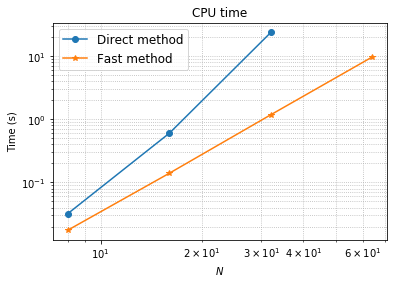

In [30]:
fig, ax = plt.subplots()
ax.loglog(N, cost_direct, 'o-', label='Direct method')
ax.loglog(N_fast, cost_fast, '*-', label='Fast method')
ax.set_xlabel('$N$')
ax.set_ylabel('Time (s)')
ax.set_title('CPU time')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')
plt.savefig('CPU time.pdf')
plt.show()

$e=0.2$, Spherical design number $= 32$

| N | Direct method | Fast method |
| ------ | ------ | ------ |
| 8 | 32.2ms | 17.6ms |
| 16 | 602ms | 140ms |
| 32 | 23.7s | 1.18s|
| 64 | -- | 9.7s |

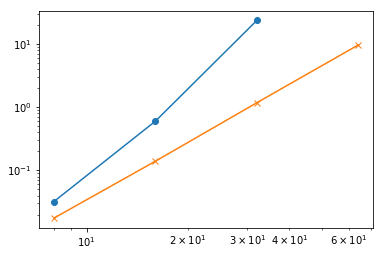

In [22]:
N = [8, 16, 32]
cost_direct = [32.2e-3, 6.02e-1, 23.7]
fig, ax = plt.subplots()
ax.loglog(N, cost_direct, 'o-', label='Computation time$')
ax.loglog(N_fast, cost_fast, 'x-', label='Computation time$')

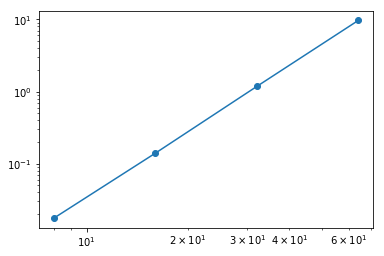

In [21]:
N_fast = [8, 16, 32, 64]
cost_fast = [17.6e-3, 1.40e-1, 1.18, 9.7]
fig, ax = plt.subplots()
ax.loglog(N_fast, cost_fast, 'o-', label='Computation time$')

In [ ]:
# 6, 223ms
np.max(np.abs(Q_direct - Q_1))

In [ ]:
# 12, 458ms
np.max(np.abs(Q_direct - Q_1))

In [ ]:
# 32, 1.22s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 48, 1.79s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 70, 2.5s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 94, 3.38s
np.max(np.abs(Q_1 - Q_direct))

In [ ]:
# 120, 4.43s
np.max(np.abs(Q_1 - Q_direct))

$e=0.2$, $N=32$

| Spherical Design | Error |
| ------ | ------ |
| 6 | 0.00041820767783433107 | 
| 12 | 3.1726851245650724e-05 |
| 32 | 6.5752814213618921e-07 |
| 48 | 5.6132233266191489e-07 |
| 70 | 2.6714628356683257e-07 |
| 94 | 1.0508293902503248e-07 |
| 120 | 2.8872928147741922e-08 | 

In [59]:
%%time
dt = 0.01
eps = 0

Q = FastSpectralCollison3D(e, 1, L, N, R, N_R, 'ss007.00032.txt')

f_hat = []

f = Q.fft3(f).copy()
for t in range(300):
    f = RK3(f, Q.col_heat_sep, eps, dt)
    f_hat.append(f)
    
f = np.real(Q.ifft3(f))
E = 0.5*np.sum(f*v_norm)*dv**3

CPU times: user 29min 30s, sys: 4min 45s, total: 34min 15s
Wall time: 16min 52s


In [44]:
%%time
T_vhs = []
for t in range(300):
    f = np.real(Q.ifft3(f_hat[t]))
    T_vhs.append(0.5*np.sum(f*v_norm)*dv**3*2/3)

CPU times: user 273 ms, sys: 31.1 ms, total: 304 ms
Wall time: 126 ms


In [60]:
%%time
T_vhs_02 = []
for t in range(300):
    f = np.real(Q.ifft3(f_hat[t]))
    T_vhs_02.append(0.5*np.sum(f*v_norm)*dv**3*2/3)

CPU times: user 266 ms, sys: 28.8 ms, total: 294 ms
Wall time: 117 ms


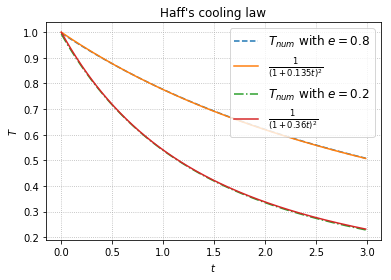

In [74]:
t = (np.arange(300)/100)

fig, ax = plt.subplots()
ax.plot(t, np.asarray(T_vhs), '--', label=r'$T_{num}$ with $e=0.8$')
ax.plot(t, 1/(1+0.135*t)**2, label=r'$\frac{1}{(1+0.135t)^2}$')
ax.plot(t, np.asarray(T_vhs_02), '-.', label=r'$T_{num}$ with $e=0.2$')
ax.plot(t, 1/(1+0.36*t)**2, label=r'$\frac{1}{(1+0.36t)^2}$')
ax.set_xlabel('$t$')
ax.set_ylabel('$T$')
ax.set_title('Haff\'s cooling law')
ax.legend(fontsize='large')
ax.grid(which='both',linestyle=':')
plt.savefig('Haff\'s_cooling.pdf')
plt.show()

# plt.plot(t, np.asarray(T_vhs), '--', t, 2.25/(1+0.36*t)**2)

In [ ]:
def T(t, e, eps, T_0):
    return (T_0 - 8*eps/(1-e**2))*np.exp(-(1-e**2)*t/4) + 8*eps/(1-e**2)

In [ ]:
# e=0.2, 003
T(1, e, eps, E_0*3/2) - E*3/2

In [ ]:
# e=0.2, 005
T(1, e, eps, E_0*3/2) - E*3/2

In [ ]:
# e=0.2, 007
T(1, e, eps, E_0*3/2) - E*3/2

In [ ]:
# e=0.2, 009
T(1, e, eps, E_0*3/2) - E*3/2

In [ ]:
# e=0.2, 011
T(1, e, eps, E_0*3/2) - E*3/2

In [ ]:
# e=0.2, 013
T(1, e, eps, E_0*3/2) - E*3/2

In [ ]:
# e=0.2, 015
T(1, e, eps, E_0*3/2) - E*3/2

$T = 1$, $\Delta t = 0.01$

| Spherical Design | 0.2 |
| ------ | ------ |
| 6 | 0.0013957739849754791 | 
| 12 | 9.9706271716293315e-05 |
| 32 | 2.2499901350947482e-06 |
| 48 | 2.4272557155313734e-06 |
| 70 | 2.4703481364962698e-06 |
| 94 | 2.4703481364962698e-06 |
| 120 | 2.453380453903975e-06 | 